<a href="https://colab.research.google.com/github/asude48/DataScienceDiabetesDiagnosis/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
data=pd.read_csv('diabetes_dataset.csv')

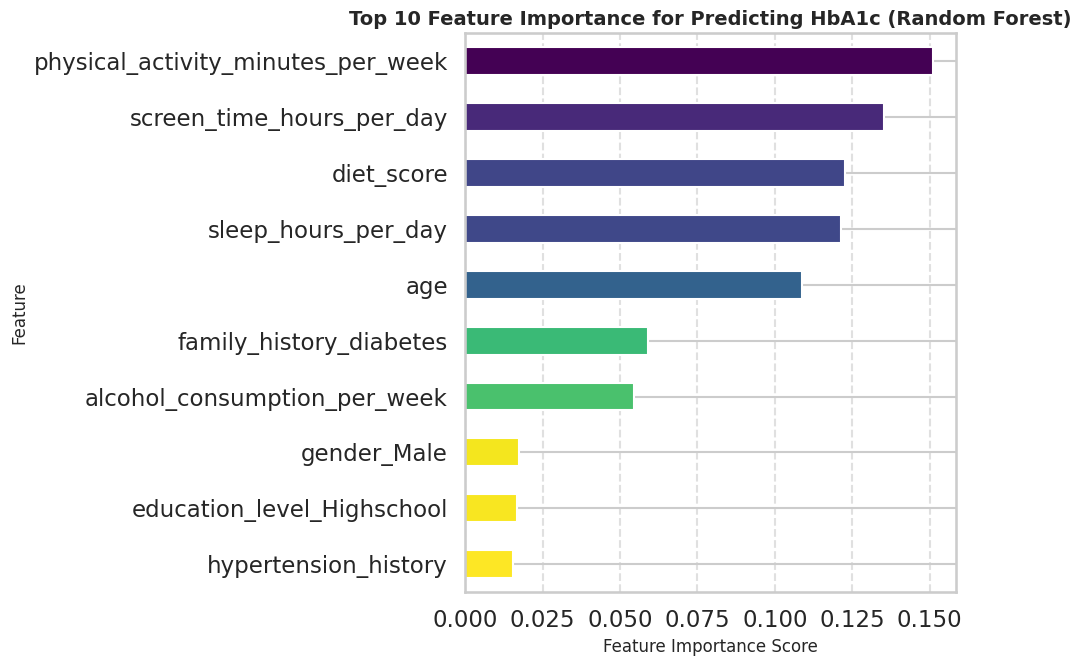

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
features = [
    'age', 'gender', 'ethnicity', 'education_level', 'income_level',
    'employment_status', 'smoking_status', 'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week', 'diet_score',
    'sleep_hours_per_day', 'screen_time_hours_per_day',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history'
]
target = 'hba1c'
X=data[features]
Y=data[target]
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)


top_10_features = feature_importances.nlargest(10)

sorted_features = top_10_features.sort_values()

# 2. Generate the Viridis Colors
# We normalize the scores (0 to max) so the colors map correctly
norm = mcolors.Normalize(vmin=sorted_features.min(), vmax=sorted_features.max())
# You can change 'viridis' to 'cividis', 'plasma', or 'inferno' here
colors = cm.viridis_r(norm(sorted_features.values))

# 3. Plot
plt.figure(figsize=(10, 7))
sorted_features.plot(kind='barh', color=colors) # <--- Apply the colors here

plt.title('Top 10 Feature Importance for Predicting HbA1c (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('hba1c_feature_importance_viridis.png', dpi=300)
plt.show()

Data Split Summary:
Training Set:   60000 patients 
Validation Set: 20000 patients 
Test Set:       20000 patients 

Training Ensemble Model...
Validation Accuracy: 84.62


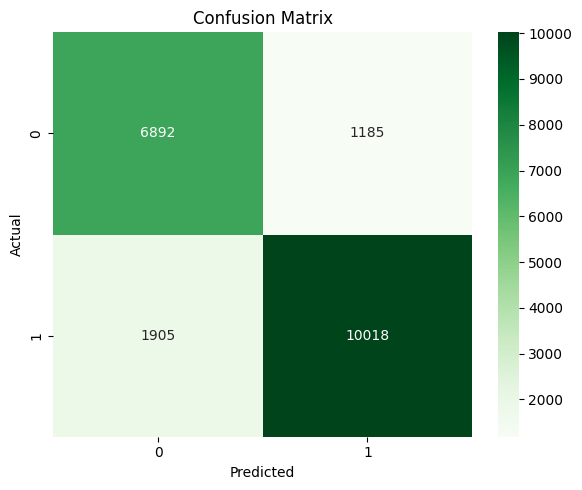


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.82      8077
           1       0.89      0.84      0.87     11923

    accuracy                           0.85     20000
   macro avg       0.84      0.85      0.84     20000
weighted avg       0.85      0.85      0.85     20000


--- FINAL RESULTS ---
Final Test Accuracy: 84.55%
Final Test ROC-AUC:  0.915

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.82      8077
           1       0.89      0.84      0.87     11923

    accuracy                           0.85     20000
   macro avg       0.84      0.85      0.84     20000
weighted avg       0.85      0.85      0.85     20000



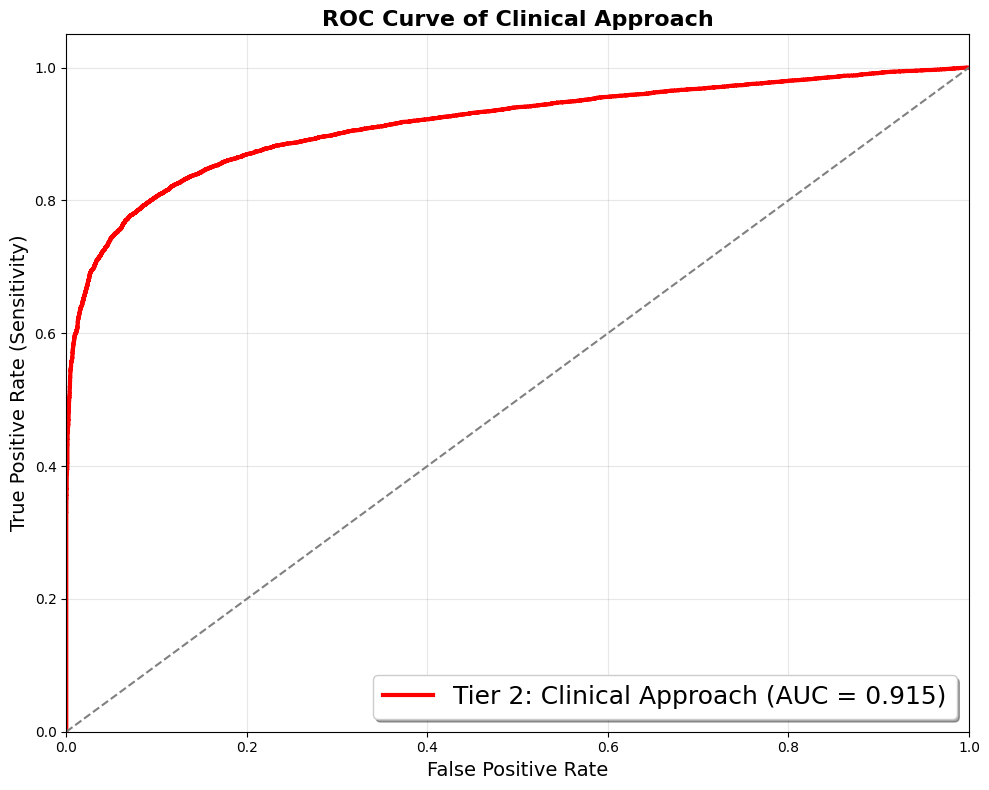

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

features = [
'glucose_postprandial','age','bmi','waist_to_hip_ratio','family_history_diabetes','physical_activity_minutes_per_week','screen_time_hours_per_day','glucose_fasting'
]
X = data[features]
y = data['diagnosed_diabetes']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


print(f"Data Split Summary:")
print(f"Training Set:   {X_train.shape[0]} patients ")
print(f"Validation Set: {X_val.shape[0]} patients ")
print(f"Test Set:       {X_test.shape[0]} patients ")

clf1 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf3 = LogisticRegression(random_state=42, max_iter=1000)

eclf = VotingClassifier(estimators=[('rf', clf1), ('gb', clf2), ('lr', clf3)], voting='soft')

print("\nTraining Ensemble Model...")
eclf.fit(X_train, y_train)

val_acc = accuracy_score(y_val, eclf.predict(X_val))
print(f"Validation Accuracy: {val_acc*100:.2f}")

y_pred = eclf.predict(X_test)
y_pred_test = eclf.predict(X_test)
y_probs_test = eclf.predict_proba(X_test)[:, 1]
fpr_ni, tpr_ni, _ = roc_curve(y_test, y_probs_test)
roc_auc_ni = auc(fpr_ni, tpr_ni)


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix_full_clinical_features.png')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n--- FINAL RESULTS ---")
print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
print(f"Final Test ROC-AUC:  {roc_auc_score(y_test, y_probs_test):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

plt.figure(figsize=(10, 8))
plt.plot(fpr_ni, tpr_ni, color='red', lw=3, label=f'Tier 2: Clinical Approach (AUC = {roc_auc_score(y_test, y_probs_test):.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ROC Curve of Clinical Approach', fontsize=16, weight='bold')
plt.legend(loc="lower right", prop={'size': 18}, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('invasive_roc.png', dpi=300)
plt.show()

Data Split Shape:
Training Set:   60000 samples (Learns the patterns)
Validation Set: 20000 samples (Tunes the threshold)
Test Set:       20000 samples (Final Exam)

--- TUNING RESULTS (Validation Set) ---
Best Threshold Found: 0.42
Validation Accuracy:  63.75%

--- FINAL TEST SET RESULTS ---
Final Accuracy: 62.87%
Final ROC-AUC:  0.657

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.40      0.46      8000
           1       0.66      0.78      0.72     12000

    accuracy                           0.63     20000
   macro avg       0.61      0.59      0.59     20000
weighted avg       0.62      0.63      0.61     20000



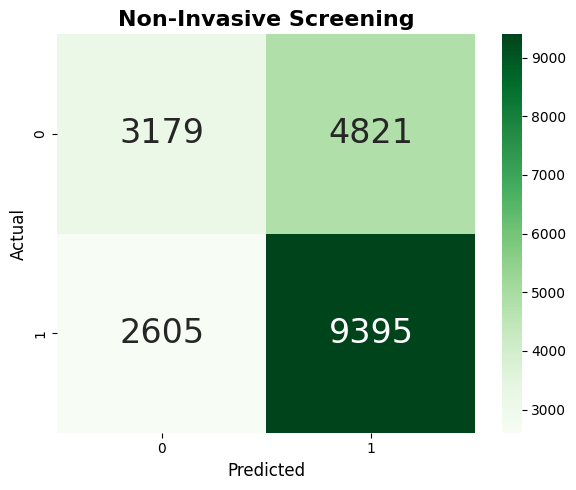

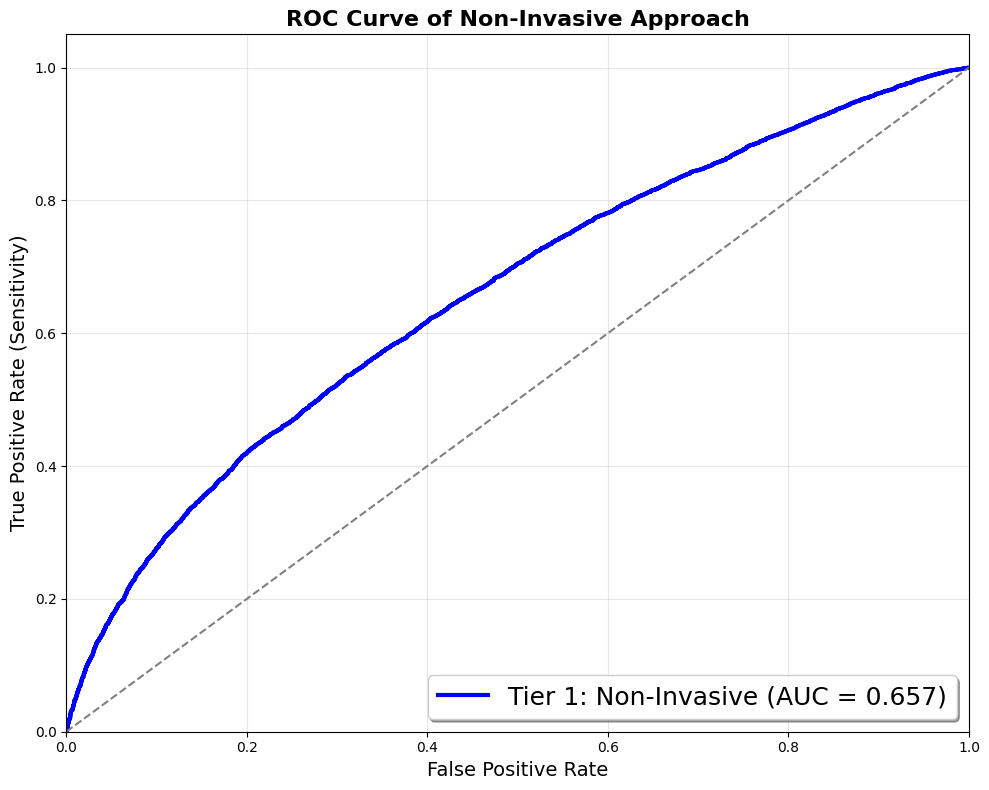

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix,roc_curve,auc


df_eng = data.copy()
df_eng['Age_BMI'] = df_eng['age'] * df_eng['bmi']
df_eng['Genetic_BMI'] = df_eng['family_history_diabetes'] * df_eng['bmi']
df_eng['Central_Obesity_Index'] = df_eng['waist_to_hip_ratio'] * df_eng['bmi']

features = [
    'age', 'bmi', 'waist_to_hip_ratio', 'family_history_diabetes',
    'physical_activity_minutes_per_week', 'screen_time_hours_per_day',
    'Age_BMI', 'Genetic_BMI', 'Central_Obesity_Index'
]

X = df_eng[features]
y = df_eng['diagnosed_diabetes']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_probs_val = model.predict_proba(X_val_scaled)[:, 1]
best_acc = 0
best_thresh = 0.5
thresholds = np.arange(0.3, 0.7, 0.01)

for thresh in thresholds:
    y_pred_temp = (y_probs_val >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_temp)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

y_probs_test = model.predict_proba(X_test_scaled)[:, 1]
fpr_ni, tpr_ni, _ = roc_curve(y_test, y_probs_test)
roc_auc_ni = auc(fpr_ni, tpr_ni)
y_pred_final = (y_probs_test >= best_thresh).astype(int)

plt.figure(figsize=(6, 5))

sns.heatmap(
    confusion_matrix(y_test, y_pred_final),
    annot=True,
    fmt='d',
    cmap='Greens',
    annot_kws={"size": 24}
)
print(f"Data Split Shape:")
print(f"Training Set:   {X_train.shape[0]} samples ")
print(f"Validation Set: {X_val.shape[0]} samples ")
print(f"Test Set:       {X_test.shape[0]} samples ")
print(f"\n--- TUNING RESULTS  ---")
print(f"Best Threshold Found: {best_thresh:.2f}")
print(f"Validation Accuracy:  {best_acc*100:.2f}%")
print(f"\n--- FINAL TEST SET RESULTS ---")
print(f"Final Accuracy: {accuracy_score(y_test, y_pred_final)*100:.2f}%")
print(f"Final ROC-AUC:  {roc_auc_score(y_test, y_probs_test):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

plt.title("Non-Invasive Screening", fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()

plt.savefig('non_invasive_screening.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(fpr_ni, tpr_ni, color='blue', lw=3, label=f'Tier 1: Non-Invasive (AUC = {roc_auc_score(y_test, y_probs_test):.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ROC Curve of Non-Invasive Approach', fontsize=16, weight='bold')
plt.legend(loc="lower right", prop={'size': 18}, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('non_invasive_roc.png', dpi=300)
plt.show()



/tmp/ipython-input-2676021331.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
/tmp/ipython-input-2676021331.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax = sns.pointplot(


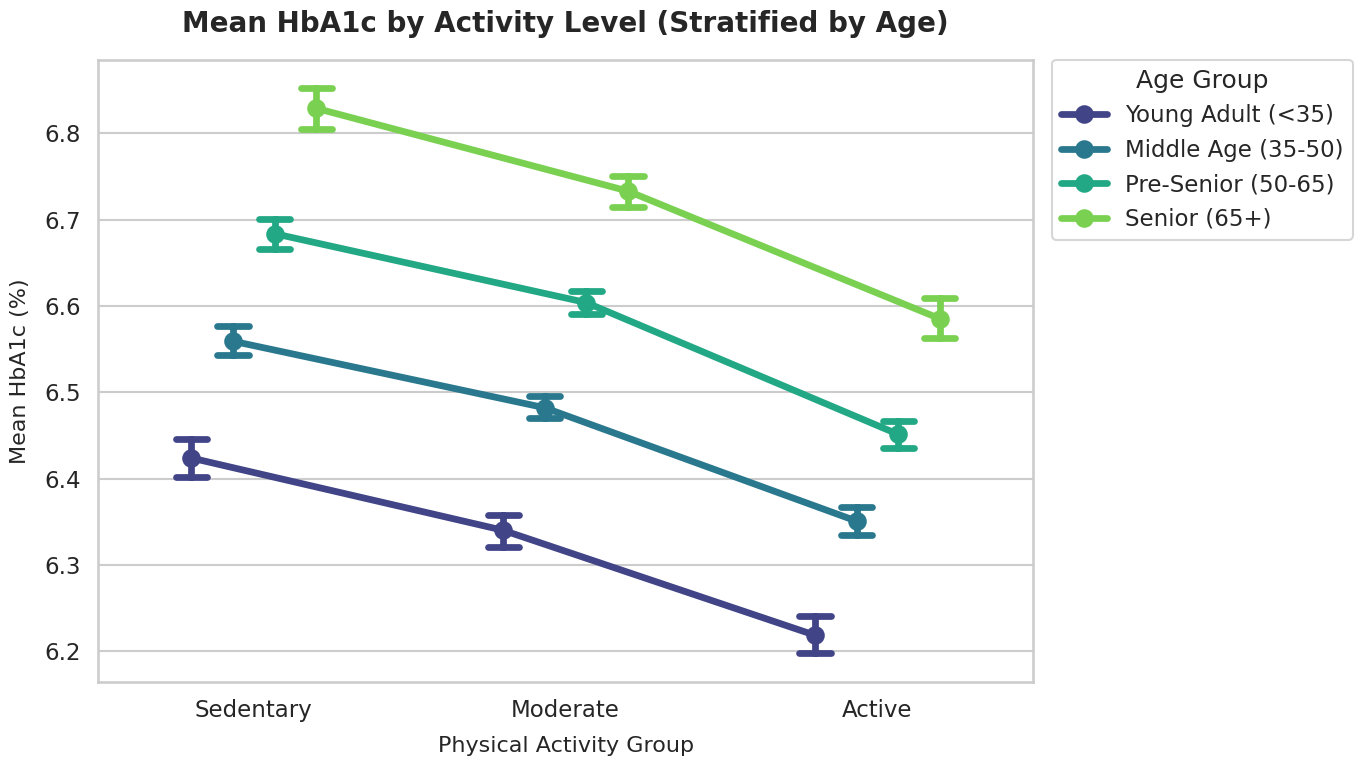

In [ ]:
if 'age_group' not in data.columns:
    data['age_group'] = pd.cut(
        data['age'],
        bins=[0, 35, 50, 65, 120],  # Refined Cutoffs
        labels=['Young Adult (<35)', 'Middle Age (35-50)', 'Pre-Senior (50-65)', 'Senior (65+)']
    )
if 'physical_activity_group' not in data.columns:
    data['physical_activity_group'] = pd.cut(data['physical_activity_minutes_per_week'], bins=[-1, 60, 150, 1000], labels=['Sedentary', 'Moderate', 'Active'])

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(14, 8))


ax = sns.pointplot(
    data=data,
    x='physical_activity_group',
    y='hba1c',
    hue='age_group',
    palette="viridis",
    dodge=0.4,
    join=True,
    capsize=0.1,
    markers="o",
    scale=1.2,
    errorbar='ci'
)


plt.title('Mean HbA1c by Activity Level (Stratified by Age)', fontsize=20, weight='bold', pad=20)
plt.xlabel('Physical Activity Group', fontsize=16, labelpad=10)
plt.ylabel('Mean HbA1c (%)', fontsize=16, labelpad=10)


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Age Group')


plt.tight_layout()
plt.savefig('stratified_interaction_plot.png', dpi=300)
plt.show()